# Packages and Functions

In [1]:
%config Completer.use_jedi = False

# Standard Python packages
import pandas as pd
import numpy as np
import collections
from IPython.display import display, display_html

# Standard plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Import Network Analysis Packages
import networkx as nx

# Science packages
from scipy.spatial.distance import squareform
from statsmodels.distributions.empirical_distribution import ECDF
from scipy import stats

# sklearn packages for Clustering
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from networkx.algorithms.community import greedy_modularity_communities

import community as community_louvain

# import self created functions
from ipynb.fs.full.functions_cluster_analysis import *
from ipynb.fs.full.functions_data_manipulation import *
from ipynb.fs.full.functions_karrer import *

# Loading the Data und Networks

In [2]:
# Main data, rename 'Probability_of_edge' to 'weight' so it is recognised as weight attribute
data = pd.read_csv("kelch_IBD_graph.csv")
data = data.rename(columns = {'Probability_of_edge':'weight', 'V1': 'source', 'V2': 'target'})

# get parasite types
codes, parasites = pd.factorize(np.concatenate((data['source'], data['target'])))
    
n = 1468            # number of parasites
n1 = data.shape[0]  # number of non-zero entries in adjacency metrix (upper triangular part) (1076778)

# add column, where parasites are indices from 0 to 1467
data['source_ind'] = codes[0:n1]
data['target_ind'] = codes[n1:(2*n1)]
data['type'] = 'undirected'

data = data.reindex(['source', 'target', 'source_ind', 'target_ind', 'weight', 'type'], axis = 1)

In [3]:
# read in meta data
meta = pd.read_csv("meta_data.csv")

# dictionary to destringize node labels, e.g. from '4' to 4
nodes_dict = {}
for key in range(1468):
    nodes_dict[str(key)] = key

In [4]:
G_bin1 = nx.relabel_nodes(nx.read_gml("Export_Graphs/G_bin1.gml"), nodes_dict)
G_bin50 = nx.relabel_nodes(nx.read_gml("Export_Graphs/G_bin50.gml"), nodes_dict)
G_sample = nx.relabel_nodes(nx.read_gml("Export_Graphs/G_sample.gml"), nodes_dict)

G_bin1_lcc = nx.relabel_nodes(nx.read_gml("Export_Graphs/G_bin1_lcc.gml"), nodes_dict)
G_bin50_lcc = nx.relabel_nodes(nx.read_gml("Export_Graphs/G_bin50_lcc.gml"), nodes_dict)
G_sample_lcc = nx.relabel_nodes(nx.read_gml("Export_Graphs/G_sample_lcc.gml"), nodes_dict)

G_sub25 = nx.relabel_nodes(nx.read_gml("Export_Graphs/G_sub25.gml"), nodes_dict)
G_sub50 = nx.relabel_nodes(nx.read_gml("Export_Graphs/G_sub50.gml"), nodes_dict)
G_sub75 = nx.relabel_nodes(nx.read_gml("Export_Graphs/G_sub75.gml"), nodes_dict)

In [5]:
# set up matrix of cluster assignments for parasites
cluster_G_bin50 = meta.copy()
cluster_G_bin1 = meta.copy()
cluster_G_sample = meta.copy()

cluster_G_bin50_lcc = meta.iloc[G_bin50_lcc].copy()
cluster_G_bin1_lcc = meta.iloc[G_bin1_lcc].copy()
cluster_G_sample_lcc = meta.iloc[G_sample_lcc].copy()

cluster_G_sub25 = meta.iloc[G_sub25].copy()
cluster_G_sub50 = meta.iloc[G_sub50].copy()
cluster_G_sub75 = meta.iloc[G_sub75].copy()

# add index so we can index later
cluster_G_bin50['index'] = cluster_G_bin50.index
cluster_G_bin1['index'] = cluster_G_bin1.index
cluster_G_sample['index'] = cluster_G_sample.index

cluster_G_bin50_lcc['index'] = cluster_G_bin50_lcc.index
cluster_G_bin1_lcc['index'] = cluster_G_bin1_lcc.index
cluster_G_sample_lcc['index'] = cluster_G_sample_lcc.index

cluster_G_sub25['index'] = cluster_G_sub25.index
cluster_G_sub50['index'] = cluster_G_sub50.index
cluster_G_sub75['index'] = cluster_G_sub75.index

# Hierarchical Clustering

In [6]:
data_lcc = filter_data(filter_data(data, 'source_ind', G_bin1_lcc), 'target_ind', G_bin1_lcc)

## Dendrograms

In [58]:
# Visualise the dendrogram first
Z = sch.linkage(1 - data['weight'], method = 'single')

plt.figure(figsize=(13,13))
dendrogram = sch.dendrogram(Z, color_threshold = 0.8)
plt.savefig("Latex/Chapter4/Appendix/G_sample_HAC_dendro.png", dpi = 400, bbox_inches = 'tight')
plt.close()

In [7]:
# Visualise the dendrogram first
Z = sch.linkage(1 - data_lcc['weight'], method = 'single')

plt.figure(figsize=(13,13))
dendrogram = sch.dendrogram(Z, color_threshold = 0.0005)
plt.savefig("Latex/Chapter4/HAC_dendro_lcc.png", dpi = 400, bbox_inches = 'tight')
plt.close()

## Cluster Assignment

In [7]:
# set up matrix of cluster assignments for parasites
hc_clust = meta.copy()
hc_lcc_clust = meta.iloc[G_bin1_lcc].copy()

# add index so we can index later
hc_clust['index'] = cluster_G_bin50.index
hc_lcc_clust['index'] = cluster_G_bin1_lcc.index

In [8]:
# perform hierarchical clustering with single linkage
A = squareform(1-data['weight'])
threshold = 0.99

m_hc = AgglomerativeClustering(n_clusters = None, distance_threshold = threshold,
                               linkage = 'single', affinity = 'precomputed')
hc_clust['HC'] = m_hc.fit_predict(A)

In [9]:
# perform hierarchical clustering with single linkage
A = squareform(1-data_lcc['weight'])
threshold = 0.0005

m_hc = AgglomerativeClustering(n_clusters = None, distance_threshold = threshold,
                               linkage = 'single', affinity = 'precomputed')
hc_lcc_clust['HC'] = m_hc.fit_predict(A)

In [10]:
# reindex
ind = 6
_, hc_clust_reindex = cluster_reindex(hc_clust, ind)
_, hc_lcc_clust_reindex = cluster_reindex(hc_lcc_clust, ind)

ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

## Visualisations

In [12]:
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(sns.color_palette('colorblind').as_hex())

In [28]:
def plt_cluster_bar(clust, x_str, hue_str,save_name, title, fontsize = 18):
    sns.set_style("whitegrid")
    df = clust.groupby([hue_str, x_str]).size().reset_index()
    df = df.pivot(columns = x_str, index = hue_str, values=0)
    
    if(len(df > 25)):
        df = df.iloc[:25,:]
    
    ax = df.plot(kind = 'bar', stacked = True, figsize = (9,5),colormap = my_cmap)
    ax.set_xticklabels("")
    ax.set_ylabel(ylabel = 'Count', fontsize = fontsize)
    ax.set_xlabel(xlabel = 'Cluster', fontsize = fontsize)
    ax.set_title(title, fontsize = fontsize)
    fig = ax.get_figure()
    fig.savefig(save_name, dpi = 400, bbox_inches = 'tight')

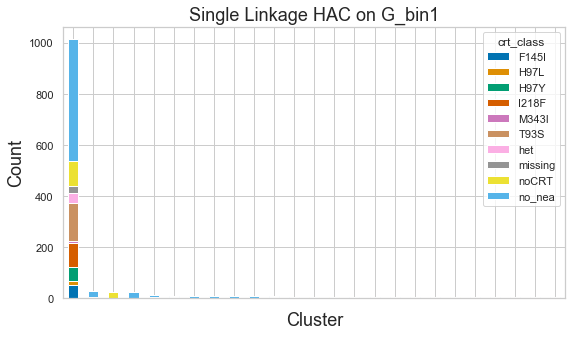

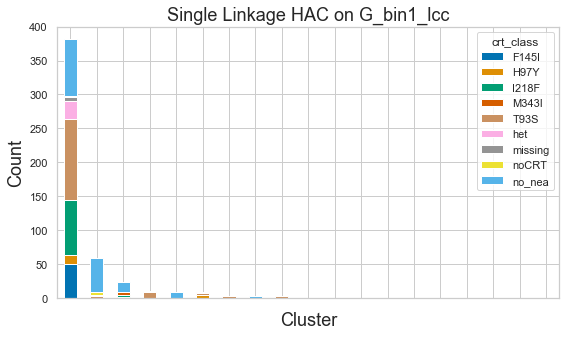

In [29]:
plt_cluster_bar(hc_clust_reindex, 'crt_class', 'HC', "Latex/Chapter4/Appendix/G_sample_HAC_bar.png",
                "Single Linkage HAC on G_bin1")
plt_cluster_bar(hc_lcc_clust_reindex, 'crt_class', 'HC', "Latex/Chapter4/G_bin1_lcc_HAC_bar.png",
                "Single Linkage HAC on G_bin1_lcc")

# Modularity Maximisation

## Louvain

In [17]:
# Louvain method
cluster_G_bin50['louvain'] = community_louvain.best_partition(G_bin50).values()
cluster_G_bin1['louvain'] = community_louvain.best_partition(G_bin1).values()
cluster_G_sample['louvain'] = community_louvain.best_partition(G_sample).values()

cluster_G_bin50_lcc['louvain'] = community_louvain.best_partition(G_bin50_lcc).values()
cluster_G_bin1_lcc['louvain'] = community_louvain.best_partition(G_bin1_lcc).values()
cluster_G_sample_lcc['louvain'] = community_louvain.best_partition(G_sample_lcc).values()

cluster_G_sub25['louvain'] = community_louvain.best_partition(G_sub25).values()
cluster_G_sub50['louvain'] = community_louvain.best_partition(G_sub50).values()
cluster_G_sub75['louvain'] = community_louvain.best_partition(G_sub75).values()

## Clauset-Newman-Moore

In [18]:
# Louvain method
cluster_G_bin50['CNM'] = clauset(G_bin50)
cluster_G_bin1['CNM'] = clauset(G_bin1)
cluster_G_sample['CNM'] = clauset(G_sample)

cluster_G_bin50_lcc['CNM'] = clauset(G_bin50_lcc)[cluster_G_bin50_lcc.index]
cluster_G_bin1_lcc['CNM'] = clauset(G_bin1_lcc)[cluster_G_bin1_lcc.index]
cluster_G_sample_lcc['CNM'] = clauset(G_sample_lcc)[cluster_G_sample_lcc.index]

cluster_G_sub25['CNM'] = clauset(G_sub25)[cluster_G_sub25.index]
cluster_G_sub50['CNM'] = clauset(G_sub50)[cluster_G_sub50.index]
cluster_G_sub75['CNM'] = clauset(G_sub75)[cluster_G_sub75.index]

In [19]:
ind = 6
cluster_G_bin50_size, cluster_G_bin50_reindex = cluster_reindex(cluster_G_bin50, ind)
cluster_G_bin1_size, cluster_G_bin1_reindex = cluster_reindex(cluster_G_bin1, ind)
cluster_G_sample_size, cluster_G_sample_reindex = cluster_reindex(cluster_G_sample, ind)

cluster_G_bin50_lcc_size, cluster_G_bin50_lcc_reindex = cluster_reindex(cluster_G_bin50_lcc, ind)
cluster_G_bin1_lcc_size, cluster_G_bin1_lcc_reindex = cluster_reindex(cluster_G_bin1_lcc, ind)
cluster_G_sample_lcc_size, cluster_G_sample_lcc_reindex = cluster_reindex(cluster_G_sample_lcc, ind)

cluster_G_sub25_size, cluster_G_sub25_reindex = cluster_reindex(cluster_G_sub25, ind)
cluster_G_sub50_size, cluster_G_sub50_reindex = cluster_reindex(cluster_G_sub50, ind)
cluster_G_sub75_size, cluster_G_sub75_reindex = cluster_reindex(cluster_G_sub75, ind)

ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.functions_cluster_analysis:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

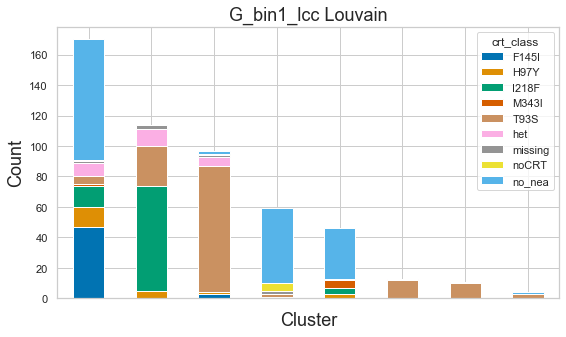

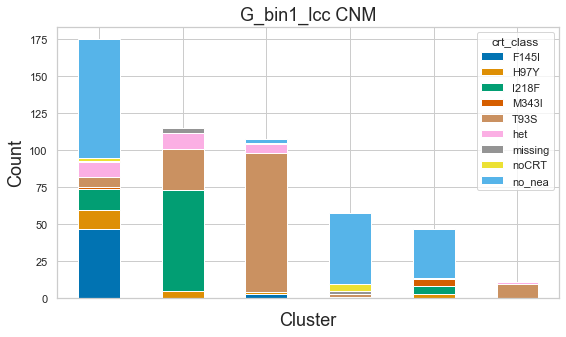

In [30]:
plt_cluster_bar(cluster_G_bin1_lcc_reindex, 'crt_class', 'louvain', "Latex/Chapter4/G_bin1_lcc_louvain_bar.png", "G_bin1_lcc Louvain")
plt_cluster_bar(cluster_G_bin1_lcc_reindex, 'crt_class', 'CNM', "Latex/Chapter4/G_bin1_lcc_cnm_bar.png", "G_bin1_lcc CNM")

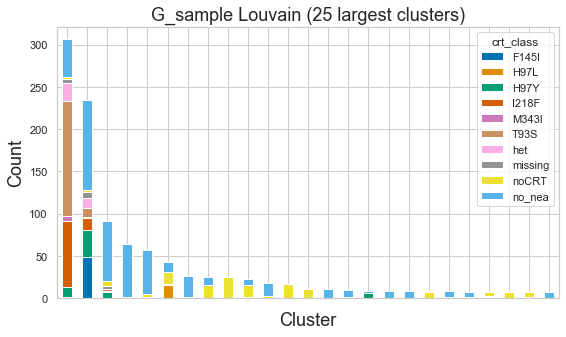

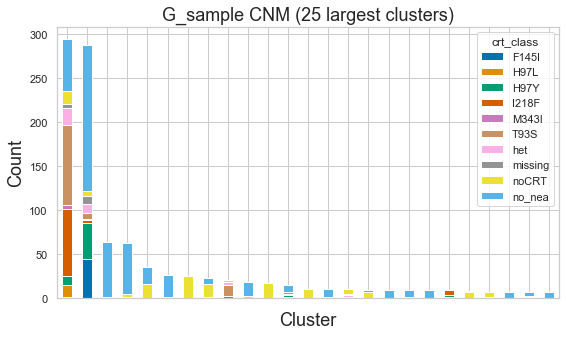

In [31]:
plt_cluster_bar(cluster_G_sample_reindex, 'crt_class', 'louvain', "Latex/Chapter4/Appendix/G_sample_louvain_bar.png",
                "G_sample Louvain (25 largest clusters)")
plt_cluster_bar(cluster_G_sample_reindex, 'crt_class', 'CNM', "Latex/Chapter4/Appendix/G_sample_cnm_bar.png",
                "G_sample CNM (25 largest clusters)")

## Computing Modularity Score

In [18]:
import community

def cluster_to_part(clust, str_col):
    part = {}

    for i in clust['index']:
        part[i] = clust[str_col][i]
        
    return(part)

In [45]:
print("G_bin50 CNM: ", np.round(community.modularity(cluster_to_part(cluster_G_bin50_reindex, 'CNM'),
                                               G_bin50),3))
print("G_bin50 Louvain: ", np.round(community.modularity(cluster_to_part(cluster_G_bin50_reindex, 'louvain'),
                                                   G_bin50),3))
print("G_bin1 CNM: ", np.round(community.modularity(cluster_to_part(cluster_G_bin1_reindex, 'CNM'),
                                               G_bin1),3))
print("G_bin1 Louvain: ", np.round(community.modularity(cluster_to_part(cluster_G_bin1_reindex, 'louvain'),
                                                   G_bin1),3))
print("G_sample CNM: ", np.round(community.modularity(cluster_to_part(cluster_G_sample_reindex, 'CNM'),
                                               G_sample),3))
print("G_sample Louvain: ", np.round(community.modularity(cluster_to_part(cluster_G_sample_reindex, 'louvain'),
                                                   G_sample),3))

print("\n")
print("G_bin50_lcc CNM: ", np.round(community.modularity(cluster_to_part(cluster_G_bin50_lcc_reindex, 'CNM'),
                                               G_bin50_lcc),3))
print("G_bin50_lcc Louvain: ", np.round(community.modularity(cluster_to_part(cluster_G_bin50_lcc_reindex, 'louvain'),
                                                   G_bin50_lcc),3))
print("G_bin1_lcc CNM: ", np.round(community.modularity(cluster_to_part(cluster_G_bin1_lcc_reindex, 'CNM'),
                                               G_bin1_lcc),3))
print("G_bin1_lcc Louvain: ", np.round(community.modularity(cluster_to_part(cluster_G_bin1_lcc_reindex, 'louvain'),
                                                   G_bin1_lcc),3))
print("G_sample_lcc CNM: ", np.round(community.modularity(cluster_to_part(cluster_G_sample_lcc_reindex, 'CNM'),
                                               G_sample_lcc),3))
print("G_sample_lcc Louvain: ", np.round(community.modularity(cluster_to_part(cluster_G_sample_lcc_reindex, 'louvain'),
                                                   G_sample_lcc),3))
print("\n")
print("G_sub25 CNM: ", np.round(community.modularity(cluster_to_part(cluster_G_sub25_reindex, 'CNM'),
                                               G_sub25),3))
print("G_sub25 Louvain: ", np.round(community.modularity(cluster_to_part(cluster_G_sub25_reindex, 'louvain'),
                                                   G_sub25),3))
print("G_sub50 CNM: ", np.round(community.modularity(cluster_to_part(cluster_G_sub50_reindex, 'CNM'),
                                               G_sub50),3))
print("G_sub50 Louvain: ", np.round(community.modularity(cluster_to_part(cluster_G_sub50_reindex, 'louvain'),
                                                   G_sub50),3))
print("G_sub75 CNM: ", np.round(community.modularity(cluster_to_part(cluster_G_sub75_reindex, 'CNM'),
                                               G_sub75),3))
print("G_sub75 Louvain: ", np.round(community.modularity(cluster_to_part(cluster_G_sub75_reindex, 'louvain'),
                                                   G_sub75),3))

G_bin50 CNM:  0.242
G_bin50 Louvain:  0.257
G_bin1 CNM:  0.593
G_bin1 Louvain:  0.605
G_sample CNM:  0.23
G_sample Louvain:  0.258


G_bin50_lcc CNM:  0.202
G_bin50_lcc Louvain:  0.217
G_bin1_lcc CNM:  0.539
G_bin1_lcc Louvain:  0.545
G_sample_lcc CNM:  0.208
G_sample_lcc Louvain:  0.237


G_sub25 CNM:  0.152
G_sub25 Louvain:  0.18
G_sub50 CNM:  0.185
G_sub50 Louvain:  0.193
G_sub75 CNM:  0.202
G_sub75 Louvain:  0.214


In [254]:
print("cluster_G_bin50_reindex")
print(cluster_G_bin50_reindex.max()[6:]+1)
print("cluster_G_bin1_reindex")
print(cluster_G_bin1_reindex.max()[6:]+1)
print("cluster_G_sample_reindex")
print(cluster_G_sample_reindex.max()[6:]+1)

print("cluster_G_bin50_lcc_reindex")
print(cluster_G_bin50_lcc_reindex.max()[6:]+1)
print("cluster_G_bin1_lcc_reindex")
print(cluster_G_bin1_lcc_reindex.max()[6:]+1)
print("cluster_G_sample_lcc_reindex")
print(cluster_G_sample_lcc_reindex.max()[6:]+1)

print("cluster_G_sub25_reindex")
print(cluster_G_sub25_reindex.max()[6:]+1)
print("cluster_G_sub50_reindex")
print(cluster_G_sub50_reindex.max()[6:]+1)
print("cluster_G_sub75_reindex")
print(cluster_G_sub75_reindex.max()[6:]+1)

cluster_G_bin50_reindex
louvain    337
CNM        366
dtype: object
cluster_G_bin1_reindex
louvain    544
CNM        544
dtype: object
cluster_G_sample_reindex
louvain    284
CNM        327
dtype: object
cluster_G_bin50_lcc_reindex
louvain     7
CNM        43
dtype: object
cluster_G_bin1_lcc_reindex
louvain    8
CNM        6
dtype: object
cluster_G_sample_lcc_reindex
louvain    16
CNM        69
dtype: object
cluster_G_sub25_reindex
louvain      2
CNM        103
dtype: object
cluster_G_sub50_reindex
louvain     3
CNM        47
dtype: object
cluster_G_sub75_reindex
louvain     4
CNM        19
dtype: object


# Visualisations

In [41]:
def plt_graph_clusters(G, pos, clustering, label_dict, title, save_file, plt_size, font_size, dpi, color_bool):
    '''Plt network graph with clusters. Use plt_size = 120 for LCC, and plt_size = 200 for full network.
    Example: plt_graph_clusters(H, pos, graph_clusters, label_dict = label_dict,
                  title = "Clustering", save_file = "test_clauset.png", plt_size = 200)'''
    # get colours
    my_cmap = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple',
           'tab:brown','tab:pink','tab:olive','tab:cyan']
    my_markers = ['o', 'v', '*', 'h','s','p', 'P']
    col_list = list(itertools.product(*[my_markers, my_cmap]))
    
    # plot graph
    fig = plt.figure(figsize = (plt_size*1.2, plt_size))
    fraction = plt_size/270
    
    # Draw nodes
    for i in range(clustering.min(), clustering.max()+1):
        # get list of nodes to colour
        nodelist = list(clustering.index[clustering == i])
        
        # colour "too long" clusters with gray diamonds
        if(i == 36):
            label = '>' + str(36+1)
            my_mark = 'D'
            my_col = 'gray'
        elif(i > 36):
            label = ''
            my_mark = 'D'
            my_col = 'gray'
        else:
            label = str(i + 1) + " (" + str(len(nodelist)) + ")"
            my_mark, my_col = col_list[i]
        
        # Draw nodes within speicfic cluster
        nx.draw_networkx_nodes(G, pos = pos, nodelist = nodelist,
                               node_color = my_col, node_shape = my_mark, node_size = 3000*fraction,
                               label = label) # edgecolors = 'tan' 
    
    # Draw edges
    if (color_bool):
        # add colorbar if color_bool == True
        weights_edge = list((nx.get_edge_attributes(G, 'weight').values()))
        my_cmap = plt.get_cmap('RdYlGn')
        nx.draw_networkx_edges(G, pos = pos, width = 1.6, edge_color = weights_edge, alpha = 0.3,
                             edge_cmap = my_cmap, edge_vmin = 0, edge_vmax = 1)

        # add colorbar
        sm = plt.cm.ScalarMappable(cmap = my_cmap, norm = plt.Normalize(vmin = 0, vmax = 1))
        sm._A = []
        cbar = plt.colorbar(sm, shrink = 0.3, pad = 0.01, orientation="horizontal")
        cbar.ax.tick_params(labelsize = plt_size*1.3)

    else:
        # Otherwise leave gray
        # nx.draw_networkx_edges(G, pos = pos, width = 4, alpha = 0.8, edge_color = '#DCDCDC')
        nx.draw_networkx_edges(G, pos = pos, width = 5, alpha = 0.5, edge_color = '#000000')
    
    # Add legend on the side
    lg = plt.legend(scatterpoints = 1, markerscale = 15*fraction, prop = {'size': plt_size},
               title = "Cluster (size)", title_fontsize = plt_size*1.1,
               bbox_to_anchor = (1.004, 1.0), loc = 'upper left')
    plt.tight_layout()
    plt.title(title, fontsize = plt_size*2, pad = plt_size*1.1)
    
    # save plot
    plt.savefig(save_file, dpi = dpi, bbox_extra_artists = (lg,), bbox_inches = 'tight')
    plt.close(fig)
    
sns.set_style("white")

## G_bin1_lcc

In [35]:
# convert nodes from numbers to parasite names
parasites_dict = {}
for key, value in enumerate(parasites):
    parasites_dict[key] = value
    
parasites_dict_lcc = {n: lab for n, lab in parasites_dict.items() if n in G_bin1_lcc}

In [36]:
pos = nx.nx_agraph.graphviz_layout(G_bin1_lcc, prog = 'neato')
label_dict = parasites_dict

# Plot characteristics
plt_size = 30
dpi = 70
font_size = 32
color_bool = False

### HAC

In [37]:
# change for specific below
G = G_bin1_lcc.copy()
clustering = hc_lcc_clust_reindex['HC']
# clustering.index = lcc_ind
label_dict = parasites_dict_lcc

str_save = "Latex/Chapter4/G_bin1_lcc_HAC.png"
str_title = "HAC clustering of G_bin1_lcc"

plt_graph_clusters(G, pos, clustering, label_dict, str_title, str_save, plt_size, font_size, dpi, color_bool)

### Louvain

In [38]:
# change for specific below
G = G_bin1_lcc.copy()
clustering = cluster_G_bin1_lcc_reindex['louvain']
# clustering.index = lcc_ind
label_dict = parasites_dict_lcc

str_save = "Latex/Chapter4/G_bin1_lcc_louvain.png"
str_title = "Louvain clustering of G_bin1_lcc"

plt_graph_clusters(G, pos, clustering, label_dict, str_title, str_save, plt_size, font_size, dpi, color_bool)

### CNM

In [39]:
# change for specific below
G = G_bin1_lcc.copy()
clustering = cluster_G_bin1_lcc_reindex['CNM']
# clustering.index = lcc_ind
label_dict = parasites_dict_lcc

str_save = "Latex/Chapter4/G_bin1_lcc_cnm.png"
str_title = "CNM clustering of G_bin1_lcc"

plt_graph_clusters(G, pos, clustering, label_dict, str_title, str_save, plt_size, font_size, dpi, color_bool)

## G_sample

In [40]:
pos = nx.nx_agraph.graphviz_layout(G_sample, prog = 'neato')
label_dict = parasites_dict

# Plot characteristics
plt_size = 30
dpi = 70
font_size = 32
color_bool = False

### HAC

In [42]:
# change for specific below
G = G_sample.copy()
clustering = hc_clust_reindex['HC']
# clustering.index = lcc_ind
label_dict = parasites_dict_lcc

str_save = "Latex/Chapter4/Appendix/G_sample_HAC.png"
str_title = "Single linkage HAC clustering of G_sample"

plt_graph_clusters(G, pos, clustering, label_dict, str_title, str_save, plt_size, font_size, dpi, color_bool)

### Louvain

In [45]:
# change for specific below
G = G_sample.copy()
clustering = cluster_G_sample_reindex['louvain']
# clustering.index = lcc_ind
label_dict = parasites_dict

str_save = "Latex/Chapter4/Appendix/G_sample_louvain.png"
str_title = "Louvain clustering for G_sample"

plt_graph_clusters(G, pos, clustering, label_dict, str_title, str_save, plt_size, font_size, dpi, color_bool)

### CNM

In [46]:
# change for specific below
G = G_sample.copy()
clustering = cluster_G_sample_reindex['CNM']
# clustering.index = lcc_ind
label_dict = parasites_dict

str_save = "Latex/Chapter4/Appendix/G_sample_cnm.png"
str_title = "CNM clustering for G_sample"

plt_graph_clusters(G, pos, clustering, label_dict, str_title, str_save, plt_size, font_size, dpi, color_bool)